In [2]:
import torch

In [3]:
def intersection_over_union(boxes_preds, boxes_labels, box_format='midpoint'):
    '''
    Calculates intersection over union

    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint\corners, if boxes (x, y, w, h) or (x1, y1, x2, y2)

    Returns:
        tensor: Intersection over union for all examples
    '''


    # boxes_preds shape is (N, 4) where N is the number of boxes
    # boxes_labels shape is (N, 4)

    if box_format == 'midpoint':
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    elif box_format == 'corners':
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4] # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]


    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    # box1_area = abs((box1_x2 - box1_x1) * (box1_y1 - box1_y2))
    # box2_area = abs((box2_x2 - box2_x1) * (box2_y1 - box2_y2))

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

<>:2: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\c'
C:\Users\w10195102\AppData\Local\Temp\ipykernel_23688\3021620065.py:2: SyntaxWarning: invalid escape sequence '\c'
  '''


In [4]:
# ---------------------------
# Tensor slicing:
#
# [:, _] --> take all values along the FIRST dimension,
#            then slice the SECOND dimension as specified.
# (Good for 2D tensors like (N, 4))
#
# [..., _] --> take all values across ALL dimensions EXCEPT the LAST,
#                then slice the LAST dimension as specified.
# (Good for any tensor: 2D, 3D, 4D, etc.)
# (Future-proof if using batches, like (B, N, 4))
#
# Example:
#   tensor shape (N, 4):
#       [:, 0:1] == [..., 0:1]   --> both OK
#
#   tensor shape (B, N, 4):
#       [:, 0:1] --> WRONG
#       [..., 0:1] --> CORRECT
#
# Bottom line:
#   Use [..., ] for better generalization across different tensor shapes.
# ---------------------------


In [5]:
# Non Max suppression

def non_max_suppression(bboxes, iou_threshold, box_format):
    """
    Performs Non-Max Suppression (NMS) on bounding boxes.

    Parameters:
        bboxes (list): List of bounding boxes with each box specified as 
                       [class, confidence, x1, y1, x2, y2] if box_format="corners".
        iou_threshold (float): IoU threshold for suppressing overlapping boxes.
        box_format (str): "corners" or "midpoint" to specify bounding box format.

    Returns:
        list: Remaining bounding boxes after applying NMS.
    """

    # bboxes is expected to be in the format of [[class, iou, x1, y1, x2, y2], [...], [...], ...]

    assert type(bboxes) == list
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)

    nms_bboxes = []

    while bboxes:
        chosen_bbox = bboxes.pop(0)
        bboxes = [box for box in bboxes if box[0] != chosen_bbox[0] or intersection_over_union(torch.tensor(box[2:]), torch.tensor(chosen_bbox[2:]), box_format=box_format) < iou_threshold]

        nms_bboxes.append(chosen_bbox)

    return sorted(nms_bboxes, key=lambda x:x[0])

bboxes = [
    [0, 0.95, 100, 100, 200, 200],   # Box A: High confidence
    [0, 0.60, 110, 110, 210, 210],   # Box B: Overlaps Box A (same class)
    [0, 0.80, 400, 400, 500, 500],   # Box C: Same class, no overlap
    [0, 0.30, 405, 405, 495, 495],   # Box D: Overlaps Box C (same class)
    
    [1, 0.92, 100, 100, 200, 200],   # Box E: Different class, overlaps Box A
    [1, 0.40, 105, 105, 195, 195],   # Box F: Overlaps Box E (same class)
    [1, 0.50, 600, 600, 700, 700],   # Box G: No overlap
    
    [2, 0.88, 150, 150, 250, 250],   # Box H: Different class, slight overlap with A/E
    [2, 0.65, 152, 152, 248, 248],   # Box I: Overlaps with H
    [2, 0.45, 700, 700, 800, 800],   # Box J: No overlap
]


nms_box = non_max_suppression(bboxes=bboxes, iou_threshold=0.5, box_format='corners')
nms_box


[[0, 0.95, 100, 100, 200, 200],
 [0, 0.8, 400, 400, 500, 500],
 [1, 0.92, 100, 100, 200, 200],
 [1, 0.5, 600, 600, 700, 700],
 [2, 0.88, 150, 150, 250, 250],
 [2, 0.45, 700, 700, 800, 800]]

In [6]:
bboxes = [
    [0, 0.95, 150, 150, 100, 100],   # A: High confidence
    [0, 0.60, 155, 155, 100, 100],   # B: Overlaps A, same class
    [0, 0.75, 500, 500, 120, 120],   # C: Distant box, same class
    [0, 0.40, 510, 510, 110, 110],   # D: Overlaps C, lower confidence
    
    [1, 0.92, 150, 150, 100, 100],   # E: Diff class, same location as A
    [1, 0.45, 148, 152, 90, 90],     # F: Overlaps E, lower conf
    [1, 0.70, 800, 800, 130, 130],   # G: No overlap

    [2, 0.88, 300, 300, 90, 90],     # H: New class
    [2, 0.65, 305, 305, 88, 88],     # I: Overlaps H
    [2, 0.60, 700, 700, 120, 120],   # J: Distant box

    [3, 0.91, 400, 400, 150, 150],   # K: Another class
    [3, 0.50, 410, 410, 140, 140],   # L: Overlaps K
    [3, 0.30, 600, 600, 100, 100],   # M: Isolated, low conf

    [4, 0.85, 200, 200, 80, 80],     # N: Unique class
    [4, 0.55, 205, 205, 80, 80],     # O: Overlaps N
]

nms_box = non_max_suppression(bboxes=bboxes, iou_threshold=0.5, box_format='midpoint')
nms_box

[[0, 0.95, 150, 150, 100, 100],
 [0, 0.75, 500, 500, 120, 120],
 [1, 0.92, 150, 150, 100, 100],
 [1, 0.7, 800, 800, 130, 130],
 [2, 0.88, 300, 300, 90, 90],
 [2, 0.6, 700, 700, 120, 120],
 [3, 0.91, 400, 400, 150, 150],
 [3, 0.3, 600, 600, 100, 100],
 [4, 0.85, 200, 200, 80, 80]]

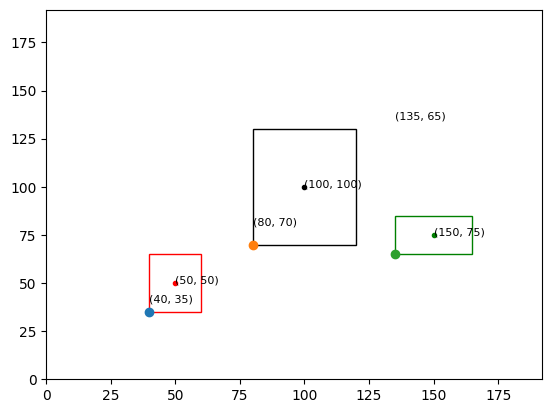

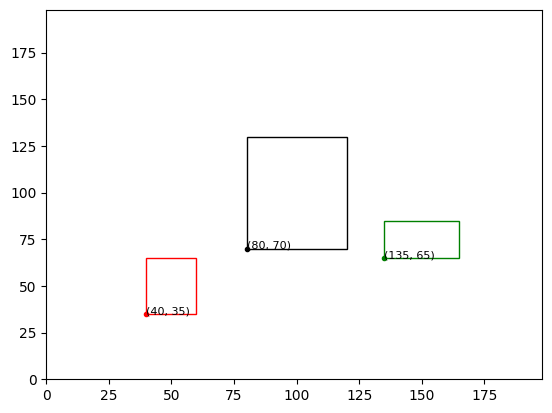

In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


def display_box(boxes, box_format):
    '''the boxes are in the format [class, iou, x1, y1, width, height]'''

    # Convert the list of bounding boxes into tensor
    bboxes = torch.tensor(boxes)

    # for the box format specified convert it into necessary coordinates to pass into the matplotlib.patches.Rectangle()
    if box_format == 'midpoint':
        # boxes in 'midpoint' box_format are expected in the format [class, iou, x1, y1, width, height] # x1 and y1 are the midpoint of box
        x1 = bboxes[..., 2:3]
        y1 = bboxes[..., 3:4]
        width = bboxes[..., 4:5]
        height = bboxes[..., 5:6]

        # here x and y correspond to the bottom left corner of the Rectangle
        x = x1 - width/2
        y = y1 - height/2

        # find the max corrdinate associated with the bounding boxes
        highest_overall = 0
        for box in bboxes:
            high_in_list = max(box[2:4])
            if high_in_list > highest_overall:
                highest_overall = high_in_list
                bigger_side = max(box[4:])
                highest_overall = highest_overall + bigger_side

    if box_format == 'corners':
        # boxes in 'corners' box_format are expected in the format [class, iou, x1, y1, x2, y2] # x1 and y1 are the nearest point form the origin and from that point across to the diagonal are the coordinates x2 and y2  
        x1 = bboxes[..., 2:3]
        y1 = bboxes[..., 3:4]
        x2 = bboxes[..., 4:5]
        y2 = bboxes[..., 5:6]
        width = (x2-x1)
        height = (y2-y1)

        # here x and y correspond to the bottom left corner of the Rectangle
        x = x1
        y = y1

        # find the max corrdinate associated with the bounding boxes
        highest_overall = 0
        highest_overall = max(max(box[2:]) for box in bboxes)

    # convert the tensor to numpy
    x = x.numpy()
    y = y.numpy()
    width = width.numpy()
    height = height.numpy()

    # list of colors for different class of boxes
    colors = ['red', 'black', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan']

    fig, ax = plt.subplots()
    
    # if the box is one dim add extra dim is added to the 0 index (to prevent any indexing error later in the code)
    if bboxes.dim() == 1:
           bboxes = bboxes.unsqueeze(dim=0)

    # loop through each of the bbox and print it out
    for i in range(len(x1)):
        box_class = int(bboxes[i][0].item())
        rect = Rectangle([x[i], y[i]], width=width[i], height=height[i], facecolor='none', edgecolor=colors[box_class])
        ax.add_patch(rect)

        # plot the coordinates along with the coordinates label

        plt.plot(x1[i], y1[i], 'o', c=colors[box_class], markersize='3')
        plt.text(x1[i], y1[i], (int(x1[i].item()), int(y1[i].item())), fontsize=8)

        if box_format == 'midpoint':
            plt.plot(x[i], y[i], 'o')
            plt.text(x[i], x[i], (int(x[i].item()), int(y[i].item())), fontsize=8)

    # Set the max width(x-axis) and height(y-axis) of the graph 
    ax.set_xlim(0, 1.2 * highest_overall)
    ax.set_ylim(0, 1.2 * highest_overall)
    plt.show()
        

midpoint_boxes = [
    [0, 0.85, 50, 50, 20, 30],
    [1, 0.75, 100, 100, 40, 60],
    [2, 0.90, 150, 75, 30, 20]
]

display_box(boxes=midpoint_boxes, box_format='midpoint')

corner_boxes = [
    [0, 0.85, 40, 35, 60, 65],   # x1 = 50 - 10, y1 = 50 - 15; x2 = 50 + 10, y2 = 50 + 15
    [1, 0.75, 80, 70, 120, 130], # x1 = 100 - 20, etc.
    [2, 0.90, 135, 65, 165, 85]
]


display_box(boxes=corner_boxes, box_format='corners')

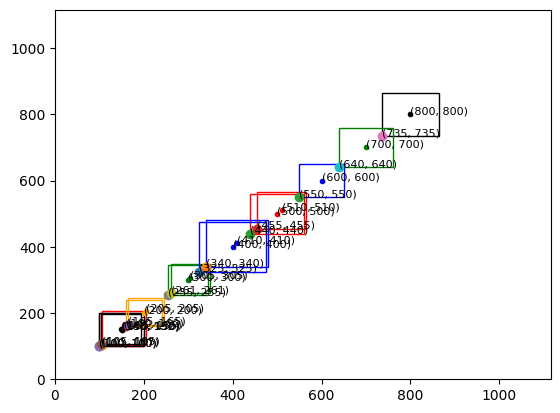

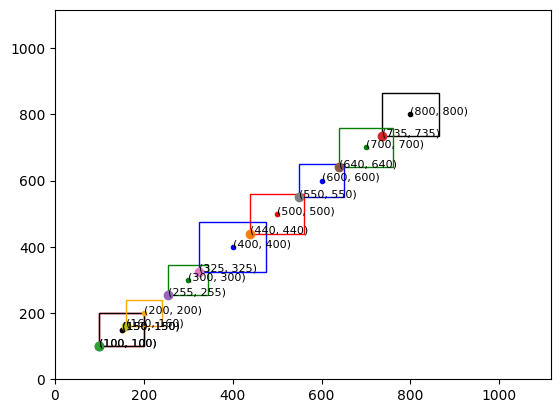

In [8]:
display_box(boxes=bboxes, box_format='midpoint')
display_box(boxes=nms_box, box_format='midpoint')

In [9]:
# Mean Average Precision
   
# take all the boxes preds as well as boxes labels and arrange them in order (by class)

# take one boxes preds('.pop(0)') and all `same class` box labels for that specific image (train index) and get theiou. if all of the values are < iou_threshold then append it to false positive list. if it has at least one value >iou_threshold then append it to the true positive list.

# repeat this for all the box preds until there are none left in the box preds

# calculate precision and recall




# precision and recall 
# true positives are the bounding box predications that share iou_threshold(0.5) with target bounding box and false positives are those that dosen't.
# false negatives means we didn't output a bounding box for a target bounding box and true negatives means we didnt output a boudning box for a target bbox that wasnt there(so we don't care about true negatives in this case).

# precision = true_positives / (true_positives + false_positives)
# out of all bounding box predictions, what fraction was actually correct

# recall = true_postives / (true_positives + false_negatives)
# out of all the target bounding boxes what fraction did we correctly detect

# different application may prioritize recall and others precision


In [43]:
gt_boxes = [
    [0, 0, 1.0, 50, 50, 150, 150],
    [0, 1, 1.0, 30, 30, 120, 120],
    [1, 0, 1.0, 200, 200, 300, 300],
    [1, 2, 1.0, 400, 400, 500, 500],
    [1, 1, 1.0, 250, 100, 350, 200],
    [2, 2, 1.0, 100, 300, 200, 400],
    [2, 1, 1.0, 600, 600, 700, 700],
    [2, 2, 1.0, 320, 240, 420, 340],
    [3, 0, 1.0, 10, 10, 60, 60],
    [3, 2, 1.0, 500, 100, 580, 180],
    [3, 1, 1.0, 700, 700, 800, 800],
    [3, 0, 1.0, 150, 150, 250, 250],
    [3, 2, 1.0, 350, 350, 450, 450],
    [4, 0, 1.0, 60, 60, 160, 160],
    [4, 1, 1.0, 80, 80, 180, 180],
    [4, 2, 1.0, 220, 220, 320, 320],
    [4, 0, 1.0, 370, 370, 470, 470],
    [4, 2, 1.0, 90, 90, 190, 190],
    [4, 1, 1.0, 170, 170, 270, 270],
    [4, 0, 1.0, 310, 310, 410, 410],
]



pred_boxes = [
    [0, 0, 0.95, 52, 52, 148, 148],
    [0, 1, 0.90, 28, 28, 125, 125],
    [1, 0, 0.88, 205, 205, 295, 295],
    [1, 2, 0.85, 398, 398, 502, 502],
    [1, 1, 0.70, 255, 105, 345, 195],
    [2, 2, 0.75, 110, 310, 190, 390],
    [2, 1, 0.65, 605, 605, 695, 695],
    [2, 2, 0.60, 318, 238, 422, 342],
    [3, 0, 0.80, 12, 12, 58, 58],
    [3, 2, 0.77, 498, 98, 582, 182],
    [3, 1, 0.92, 705, 705, 795, 795],
    [3, 0, 0.87, 155, 155, 245, 245],
    [3, 2, 0.66, 352, 352, 448, 448],
    [4, 0, 0.73, 62, 62, 158, 158],
    [4, 1, 0.69, 85, 85, 175, 175],
    [4, 2, 0.78, 225, 225, 315, 315],
    [4, 0, 0.81, 375, 375, 465, 465],
    [4, 2, 0.64, 92, 92, 188, 188],
    [4, 1, 0.83, 172, 172, 268, 268],
    [4, 0, 0.86, 312, 312, 408, 408],
]

C:\Users\w10195102\AppData\Local\Temp\ipykernel_23688\1162060311.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bboxes = torch.tensor(boxes)


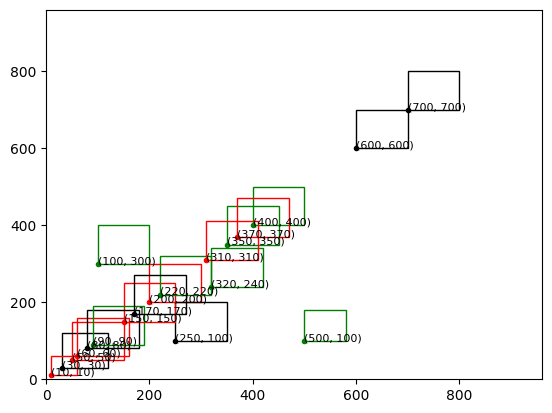

In [11]:
gt_boxes_mod = torch.tensor(gt_boxes)

# display boxes accepts in the format [class_label, iou_prob, x1, y1, x2. y2]
display_box(boxes=gt_boxes_mod[..., 1:], box_format='corners')
# display_box(boxes=pred_boxes, box_format='corners')

In [12]:
display(gt_boxes)
display(pred_boxes)

[[0, 0, 1.0, 50, 50, 150, 150],
 [0, 1, 1.0, 30, 30, 120, 120],
 [1, 0, 1.0, 200, 200, 300, 300],
 [1, 2, 1.0, 400, 400, 500, 500],
 [1, 1, 1.0, 250, 100, 350, 200],
 [2, 2, 1.0, 100, 300, 200, 400],
 [2, 1, 1.0, 600, 600, 700, 700],
 [2, 2, 1.0, 320, 240, 420, 340],
 [3, 0, 1.0, 10, 10, 60, 60],
 [3, 2, 1.0, 500, 100, 580, 180],
 [3, 1, 1.0, 700, 700, 800, 800],
 [3, 0, 1.0, 150, 150, 250, 250],
 [3, 2, 1.0, 350, 350, 450, 450],
 [4, 0, 1.0, 60, 60, 160, 160],
 [4, 1, 1.0, 80, 80, 180, 180],
 [4, 2, 1.0, 220, 220, 320, 320],
 [4, 0, 1.0, 370, 370, 470, 470],
 [4, 2, 1.0, 90, 90, 190, 190],
 [4, 1, 1.0, 170, 170, 270, 270],
 [4, 0, 1.0, 310, 310, 410, 410]]

[[0, 0, 0.95, 52, 52, 148, 148],
 [0, 1, 0.9, 28, 28, 125, 125],
 [1, 0, 0.88, 205, 205, 295, 295],
 [1, 2, 0.85, 398, 398, 502, 502],
 [1, 1, 0.7, 255, 105, 345, 195],
 [2, 2, 0.75, 110, 310, 190, 390],
 [2, 1, 0.65, 605, 605, 695, 695],
 [2, 2, 0.6, 318, 238, 422, 342],
 [3, 0, 0.8, 12, 12, 58, 58],
 [3, 2, 0.77, 498, 98, 582, 182],
 [3, 1, 0.92, 705, 705, 795, 795],
 [3, 0, 0.87, 155, 155, 245, 245],
 [3, 2, 0.66, 352, 352, 448, 448],
 [4, 0, 0.73, 62, 62, 158, 158],
 [4, 1, 0.69, 85, 85, 175, 175],
 [4, 2, 0.78, 225, 225, 315, 315],
 [4, 0, 0.81, 375, 375, 465, 465],
 [4, 2, 0.64, 92, 92, 188, 188],
 [4, 1, 0.83, 172, 172, 268, 268],
 [4, 0, 0.86, 312, 312, 408, 408]]

In [13]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import math

def display_box_in_images(pred_boxes, gt_boxes):
    pred_boxes = torch.tensor(pred_boxes)
    gt_boxes = torch.tensor(gt_boxes)
    total_img = int(max(gt_boxes[..., 0:1]).item()) + 1

    fig, ax = plt.subplots(total_img, 1, figsize=(8, 40))
    # fig, ax = plt.subplots(2, math.ceil(total_img/2), figsize=(15, 15))



    for i in range(total_img):

        ax[i].set_xlim(0, 850)
        ax[i].set_ylim(0, 850)


        # handles the prediction boxes
        ith_image = [box for box in pred_boxes if box[0] == i]
        for images in ith_image:

            x1 = images[3:4]
            y1 = images[4:5]
            x2 = images[5:6]
            y2 = images[6:7]

            width = (x2-x1)
            height = (y2-y1)
            x = x1
            y = y1
            rect = Rectangle([x, y], width=width, height=height, facecolor='none', edgecolor='red')
            ax[i].add_patch(rect)
            

        # handles the ground truth boxes
        ith_images_gt = [box for box in gt_boxes if box[0]== i]
        # print(ith_images_gt)
        for images in ith_images_gt:
            # print(images)
            x1 = images[3:4]
            y1 = images[4:5]
            x2 = images[5:6]
            y2 = images[6:7]

            # print(x1, y1, x2, y2)
            
            width = (x2-x1)
            # return
            height = (y2-y1)
            x = x1
            y = y1
            rect = Rectangle([x, y], width=width, height=height, facecolor='none', edgecolor='green')
            ax[i].add_patch(rect)



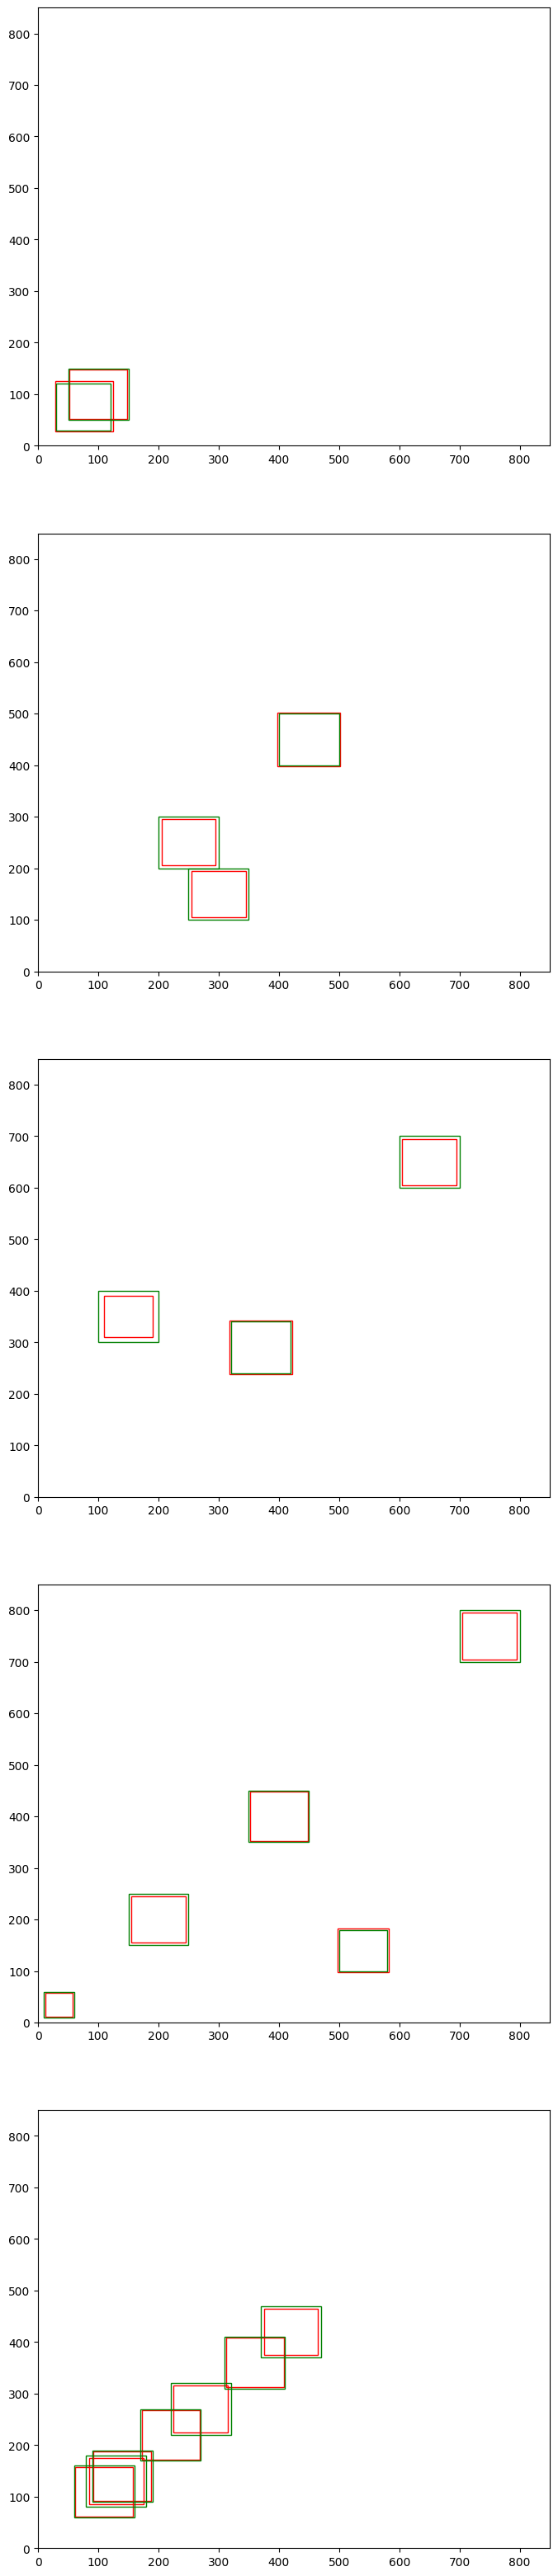

In [14]:
display_box_in_images(pred_boxes=pred_boxes, gt_boxes=gt_boxes)

In [15]:

def mean_average_precision(boxes_preds, boxes_labels, iou_threshold=0.5, box_format='corners', num_classes=20):
    
    # boxes preds (list): [[train_idx, class_pred, pred_score, x1, y1, x2, y2], [], []]
    average_precision = []

    # Iterate over each class across all the images in data to calculate the mean average precision
    for c in range(num_classes):
        predictions = []
        ground_truths = []

        # store all similar (nth loop) class of prediction boxes in the list
        for detection in boxes_preds:
            if detection[1] == c:
                predictions.append(detection)

        
        # store all similar (nth loop) class of ground truth boxes in the list
        for boxes in boxes_labels:
            if boxes[1] == c:
                ground_truths.append(boxes)

        # sort the prediction and ground truths list based on the train_idx 'image number' 
        predictions = sorted(predictions, key=lambda x:x[0])
        ground_truths = sorted(ground_truths, key=lambda x:x[0])


        # go over each of the predictions boxes and calcualte if they are true positives or false positives

        # here tp and fp are true positives and false positives
        tp = 0
        fp = 0
        while predictions:
            choosen_one = predictions.pop(0)

            # if 'choosen_one' is the bbox for 'x' image, get all the ground truth labels for the 'x' image and then later compute the iou to find which one is the true positives and false positives.....
            same_img_idx_gt = [box for box in ground_truths if box[0] == choosen_one[0]]

            # the intersection over union function requires the list to be in tensor format
            choosen_one = torch.tensor(choosen_one)
            same_img_idx_gt = torch.tensor(same_img_idx_gt)
            
            iou = intersection_over_union(boxes_preds=choosen_one[3:], boxes_labels=same_img_idx_gt[..., 3:],box_format='corners')

            print(iou)
            if max(iou) > 0.5:
                tp += 1
                print('tp')
            else:
                fp += 1
                print('fp')
            
        precision = tp / (tp + fp)



        # average precision is the area under the precision recall graph....
        # then we calculate this average precision for all the classes
        # at last we average all this average precision to get the mean average precision


    
    return average_precision


In [16]:
x = mean_average_precision(boxes_preds=pred_boxes, boxes_labels=gt_boxes, iou_threshold=0.5, box_format='corners',num_classes=3)
x

tensor([[0.9216]])
tp
tensor([[0.8100]])
tp
tensor([[0.8464],
        [0.0000]])
tp
tensor([[0.0000],
        [0.8100]])
tp
tensor([[0.9216],
        [0.0000],
        [0.0000]])
tp
tensor([[0.0000],
        [0.8100],
        [0.0726]])
tp
tensor([[0.0000],
        [0.0813],
        [0.9216]])
tp
tensor([[0.8609]])
tp
tensor([[0.8100]])
tp
tensor([[0.8100]])
tp
tensor([[0.8100]])
tp
tensor([[0.8100],
        [0.0014]])
tp
tensor([[0.0033],
        [0.9216]])
tp
tensor([[0.9246]])
tp
tensor([[0.6400],
        [0.0000]])
tp
tensor([[0.0000],
        [0.9246]])
tp
tensor([[0.9070],
        [0.0000]])
tp
tensor([[0.0000],
        [0.9216]])
tp
tensor([[0.8100],
        [0.0000]])
tp
tensor([[0.0000],
        [0.9216]])
tp


[]

In [17]:
gt_boxes = [
    [0, 0, 1.0, 50, 50, 150, 150],   # GT1 (img 0, class 0)
    [0, 1, 1.0, 30, 30, 70, 70],     # GT2 (img 0, class 1)
    [1, 0, 1.0, 60, 60, 160, 160],   # GT3 (img 1, class 0)
]


pred_boxes = [
    [0, 0, 0.9, 48, 48, 152, 152],   # P1 — matches GT1 (IoU > 0.5)
    [0, 1, 0.6, 25, 25, 75, 75],     # P2 — matches GT2 (IoU > 0.5)
    [0, 1, 0.4, 100, 100, 130, 130], # P3 — FP (low IoU with any GT)
    [1, 0, 0.95, 58, 58, 162, 162],  # P4 — matches GT3
    [1, 1, 0.5, 60, 60, 100, 100],   # P5 — wrong class, no GT → FP
]


In [18]:
mAP = mean_average_precision(boxes_preds=pred_boxes , boxes_labels=gt_boxes, iou_threshold=0.5, box_format='corners')

tensor([[0.9246]])
tp
tensor([[0.9246]])
tp
tensor([[0.6400]])
tp
tensor([[0.]])
fp
tensor([])


ValueError: max() iterable argument is empty

In [52]:
# Mean Average Precision

import torch
from collections import Counter


def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, box_format='corners', num_classes=20):
    
    # pred_boxes (list): [[train_idx, class_pred, prob_score, x1, y1, x2, y2], ...] 
    average_precisions = []
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        amount_bboxes = Counter([gt[0] for gt in ground_truths])

In [53]:
x = mean_average_precision(pred_boxes=pred_boxes, true_boxes=gt_boxes, num_classes=3)
x